In [44]:
# Let's try with sympy

import numpy as np
import sympy
embedding_dim = 2
hidden_dim = 3

def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

def expr_to_string(expr):
    return str(round_expr(expr, 2)).replace("Max(0, ", "ReLU(")

def random_matr(*shape):
    return sympy.Matrix(np.random.normal(size=shape))

A     = random_matr(hidden_dim, 2 * embedding_dim)
A_hat = random_matr(*A.shape)
b     = random_matr(hidden_dim, 1)
b_hat = random_matr(*b.shape)
C     = random_matr(hidden_dim, hidden_dim)
C_hat = random_matr(*C.shape)
d     = random_matr(hidden_dim, 1)
d_hat = random_matr(*d.shape)
E     = random_matr(1, hidden_dim)
E_hat = random_matr(*E.shape)
f     = random_matr(1, 1)
f_hat = random_matr(*f.shape)

beta = sympy.Symbol("β", real=True)

class relu(sympy.Function):
    @classmethod
    def eval(cls, x):
        return x.applyfunc(lambda elem: sympy.Max(elem, 0))

    def _eval_is_real(self):
        return True

delta_e1 = np.random.normal(size=(2 * embedding_dim, 1))
delta_e2 = np.random.normal(size=(2 * embedding_dim, 1))
# the first half of the vectors is always the same
delta_e2[:embedding_dim, :] = delta_e1[:embedding_dim, :]
delta_e1 = sympy.Matrix(delta_e1)
delta_e2 = sympy.Matrix(delta_e2)

def q(beta, x):
    result = relu((A + beta * A_hat) @ x + b + beta * b_hat)
    result = relu((C + beta * C_hat) @ result + d + beta * d_hat)
    result = (E + beta * E_hat) @ result + f + beta * f_hat
    return result

def to_scalar(x):
    assert x.shape == (1, 1)
    return x[0, 0]
    
logit = to_scalar(q(beta, delta_e1) - q(beta, delta_e2))
print(expr_to_string(logit))
dlogit_dbeta = logit.diff(beta)
print(expr_to_string(dlogit_dbeta))

-(0.63 - 0.38*β)*ReLU(-2.0*β + (0.54*β + 1.16)*ReLU(0.57 - 2.28*β) + (0.59*β - 1.12)*ReLU(1.69*β - 0.83) + (1.16*β - 1.78)*ReLU(0.9*β + 3.88) - 0.63) + (0.63 - 0.38*β)*ReLU(-2.0*β + (0.54*β + 1.16)*ReLU(2.38 - 2.13*β) + (0.59*β - 1.12)*ReLU(1.26*β + 0.11) + (1.16*β - 1.78)*ReLU(0.29 - 1.58*β) - 0.63) + (-0.73*β - 0.54)*ReLU(2.03*β + (0.24 - 1.3*β)*ReLU(1.26*β + 0.11) + (1.14*β + 0.28)*ReLU(0.29 - 1.58*β) + (1.22*β - 0.17)*ReLU(2.38 - 2.13*β) + 0.16) - (-0.73*β - 0.54)*ReLU(2.03*β + (0.24 - 1.3*β)*ReLU(1.69*β - 0.83) + (1.14*β + 0.28)*ReLU(0.9*β + 3.88) + (1.22*β - 0.17)*ReLU(0.57 - 2.28*β) + 0.16) + (0.54*β - 0.81)*ReLU(-0.69*β + (-0.14*β - 1.42)*ReLU(0.29 - 1.58*β) + (0.32*β + 1.76)*ReLU(1.26*β + 0.11) + (0.73*β + 0.4)*ReLU(2.38 - 2.13*β) + 0.33) - (0.54*β - 0.81)*ReLU(-0.69*β + (-0.14*β - 1.42)*ReLU(0.9*β + 3.88) + (0.32*β + 1.76)*ReLU(1.69*β - 0.83) + (0.73*β + 0.4)*ReLU(0.57 - 2.28*β) + 0.33)
(0.63 - 0.38*β)*(-2.13*(0.54*β + 1.16)*Heaviside(2.38 - 2.13*β) + 1.26*(0.59*β - 1.12)*Hea

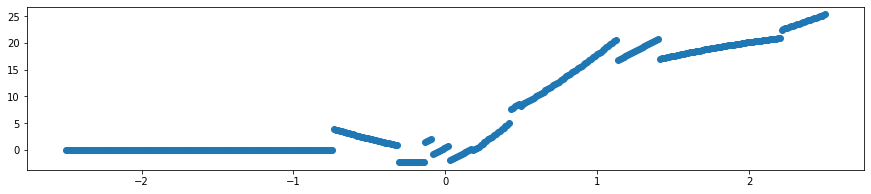

In [48]:
# let's plot dlogit_dbeta
import matplotlib.pyplot as plt

xs = np.linspace(-2.5, 2.5, 400)
ys = np.array([float(dlogit_dbeta.subs(beta, x).simplify()) for x in xs])
plt.figure(figsize=(15, 3))
plt.scatter(xs, ys);

# it is discontinuous piecewise-quadratic!

In [50]:
def estimate_upper_bound(expr, param_name, abs_param_bound):
    #print(type(expr))
    if type(expr) == sympy.Add:
        arg_bounds = [estimate_upper_bound(x, param_name, abs_param_bound) for x in expr.args]
        return sum(arg_bounds)
    if type(expr) == sympy.Mul:
        arg_bounds = [estimate_upper_bound(x, param_name, abs_param_bound) for x in expr.args]
        return np.prod(arg_bounds)
    if type(expr) == sympy.Float:
        return np.abs(float(expr))
    if type(expr) == sympy.numbers.NegativeOne:
        return 1.0
    if type(expr) == sympy.Symbol:
        if str(expr) == param_name:
            return abs_param_bound
        else:
            raise RuntimeError(f"Unexpected symbol {expr}")
    if type(expr) == sympy.Max:
        if len(expr.args) == 2 and str(expr.args[0] == "0"):
            return estimate_upper_bound(expr.args[1], param_name, abs_param_bound)
        else:
            raise RuntimeError(f"Unexpected Max expression {expr}")
    if type(expr) == sympy.Heaviside:
        return 1.0
    else:
        raise RuntimeError(f"Unexpected type {type(expr)}")

print(estimate_upper_bound(logit, "β", 10))
print(estimate_upper_bound(dlogit_dbeta, "β", 10))

poly_params = [sympy.Function(f"p{i}") for i in range(3)]
p0 = poly_params[0]
p1 = poly_params[1]
p2 = poly_params[2]
poly = 1 - p0(beta)*p1(beta) + 2*p1(beta)*p2(beta)
dpoly_dbeta = poly.diff(beta)
print(dpoly_dbeta)

18663.469201701744
5067.070224898369
-p0(β)*Derivative(p1(β), β) - p1(β)*Derivative(p0(β), β) + 2*p1(β)*Derivative(p2(β), β) + 2*p2(β)*Derivative(p1(β), β)


In [51]:
class sigmoid(sympy.Function):
    @classmethod
    def eval(cls, x):
        return (sympy.functions.elementary.hyperbolic.tanh(2 * x) + 1) / 2

    def _eval_is_real(self):
        return True

smoothing_alpha = 0.01
full_poly = 1 - ((1 - smoothing_alpha)*sigmoid(logit) + smoothing_alpha/2)
#print(full_poly)

In [52]:
%%time

from typing import *

def get_bottom_decision_points(expr, param) -> Tuple[set, bool]:
    result_set = set()
    all_args_plain = True
    for arg in expr.args:
        arg_set, arg_plain = get_bottom_decision_points(arg, param)
        result_set.update(arg_set)
        all_args_plain = all_args_plain and arg_plain
    if all_args_plain and type(expr) in [sympy.Heaviside, sympy.Max]:
        # new decision point
        index = 1 if type(expr) == sympy.Max else 0
        #solutions = [0]
        #print(expr.args[index])
        # even though the expressions are simple, this works very slowly:
        solutions = sympy.solve(expr.args[index], param)
        #assert len(solutions) == 1
        result_set.add(solutions[0])
        #print(expr, solutions[0])
        all_args_plain = False
    return result_set, all_args_plain

def to_intervals(points):
    return list(zip(points, points[1:]))

intervals = to_intervals([-np.infty] + sorted(list(get_bottom_decision_points(dlogit_dbeta, beta)[0])) + [np.infty])
print(intervals)

[(-inf, -4.31106844158925), (-4.31106844158925, -0.0899048155343415), (-0.0899048155343415, 0.180328369303251), (0.180328369303251, 0.250856856835477), (0.250856856835477, 0.494399226693203), (0.494399226693203, 1.12191672134450), (1.12191672134450, inf)]
Wall time: 8.87 s


In [53]:
%%time

def get_subs_value(interval):
    if interval[0] == -np.infty:
        return interval[1] - 1
    if interval[1] == np.infty:
        return interval[0] + 1
    return (interval[1] - interval[0]) / 2
    
def resolve_bottom_decisions(expr, param, param_point) -> Tuple[sympy.Expr, bool]:
    if type(expr) in [sympy.Float, sympy.Integer, sympy.numbers.NegativeOne, sympy.Symbol]:
        return expr, True
    if type(expr) in [sympy.Heaviside, sympy.Max]:
        return expr.subs(param, param_point).simplify(), False
    all_args_plain = True
    arg_expressions = []
    for arg in expr.args:
        arg_expr, arg_plain = resolve_bottom_decisions(arg, param, param_point)
        arg_expressions += [arg_expr]
        all_args_plain = all_args_plain and arg_plain
    #print(type(expr), arg_expressions)
    return type(expr)(*arg_expressions), all_args_plain
    
for interval in intervals:
    print(interval)
    e = resolve_bottom_decisions(dlogit_dbeta, beta, get_subs_value(interval))[0].simplify()
    final_decision_points = get_bottom_decision_points(e, beta)[0]
    final_decision_points = [p for p in final_decision_points if interval[0] < p < interval[1]]
    final_decision_points = [interval[0]] + final_decision_points + [interval[1]]
    # TODO combine
    #points = [-np.infty] + sorted(list(get_bottom_decision_points(dlogit_dbeta, beta))) + [np.infty]
    refined_intervals = to_intervals(final_decision_points)
    for refined_interval in refined_intervals:
        refined_e = resolve_bottom_decisions(e, beta, get_subs_value(refined_interval))[0].simplify()
        print(" ", refined_interval)
        print("   ", expr_to_string(refined_e))
        print("    additional points:", [x for x in sympy.solve(refined_e, beta)
                                         if refined_interval[0] < x < refined_interval[1]])

(-inf, -4.31106844158925)
  (-inf, -4.31106844158925)
    0
    additional points: []
(-4.31106844158925, -0.0899048155343415)
  (-4.31106844158925, -0.0899048155343415)
    -0.63*β**2 + 4.54*β + 13.81
    additional points: [-2.30690710046022]
(-0.0899048155343415, 0.180328369303251)
  (-0.0899048155343415, 0.180328369303251)
    3.45*β**2 + 7.0*β - 1.41
    additional points: []
(0.180328369303251, 0.250856856835477)
  (0.180328369303251, 0.250856856835477)
    3.45*β**2 + 6.65*β - 2.12
    additional points: []
(0.250856856835477, 0.494399226693203)
  (0.250856856835477, 0.494399226693203)
    3.45*β**2 + 6.95*β - 1.51
    additional points: []
(0.494399226693203, 1.12191672134450)
  (0.494399226693203, 1.12191672134450)
    3.36*β**2 + 8.56*β - 0.37
    additional points: []
(1.12191672134450, inf)
  (1.12191672134450, inf)
    -0.63*β**2 + 4.53*β + 13.85
    additional points: [9.52098708796250]
Wall time: 3.86 s
